In [6]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

In [7]:
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [8]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

def get_edges(fips, month, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `tidal-digit-291220.safegraph.2020_{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) = @fips AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

def get_graph(edges, nodes, method='direct'):
    if method == 'bundled':
        print('Bundling desire lines...')
        return hammer_bundle(nodes, edges,
                             source='focal', target='target',
                             decay=0.25,
                             x='X', y='Y')
    else:
        print('Linking desire lines...')
        return connect_edges(nodes, edges,
                             source='focal', target='target',
                             x='X', y='Y')

def composers(graph, nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)


    agg = tf.shade(canvas.line(graph, 'X', 'Y', agg=ds.count()),  cmap=palette['bmy'], how='eq_hist')
    img = tf.set_background(agg, "#000000")
    
    return img

def nodesplot(nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.points(nodes,'X','Y',agg=None)
    spr = tf.spread(tf.shade(agg, cmap=palette['CET_L7'][20]), px=8)
    
    return spr

def edgesplot(nodes, edges):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.line(edges, 'X','Y', agg=ds.count())
    spr = tf.shade(agg, cmap=palette['bmy'], how='eq_hist')
    
    return spr

def combiplot(nodes, edges):
    
    verts = nodesplot(nodes)
    links = edgesplot(nodes, edges)
    
    stack = tf.stack(verts, links)
    
    ready = tf.set_background(stack, '#000000')
    
    return ready.to_pil()

def plot_graphs_by_month(fig, data, nodes, month, x_range, y_range):
    
    temp = data[data['month']==month].drop('month', axis=1)
    
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.05,
        0.05,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
    
    ax.text(
        0.05,
        0.1,
        months[month-1],
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [18]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09"]

In [9]:
fips = '11001'

In [10]:
state = fips[:2]
county = fips[2:]

where_clause = f"STATE = {state} AND COUNTY = {county}"
shape = acs.mapservice.layers[10].query(where=where_clause)
    
shape = shape.to_crs(3857)

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
nodes = get_nodes(fips)

In [15]:
timeseries = list()

for month in months:
        
        temp = get_edges(fips, month, nodes.reset_index()['cbg'])
        temp['month'] = month
        
        timeseries.append(temp)

timeseries = pd.concat(timeseries, ignore_index=True)

In [16]:
timeseries['month'] = timeseries['month'].astype('int64')

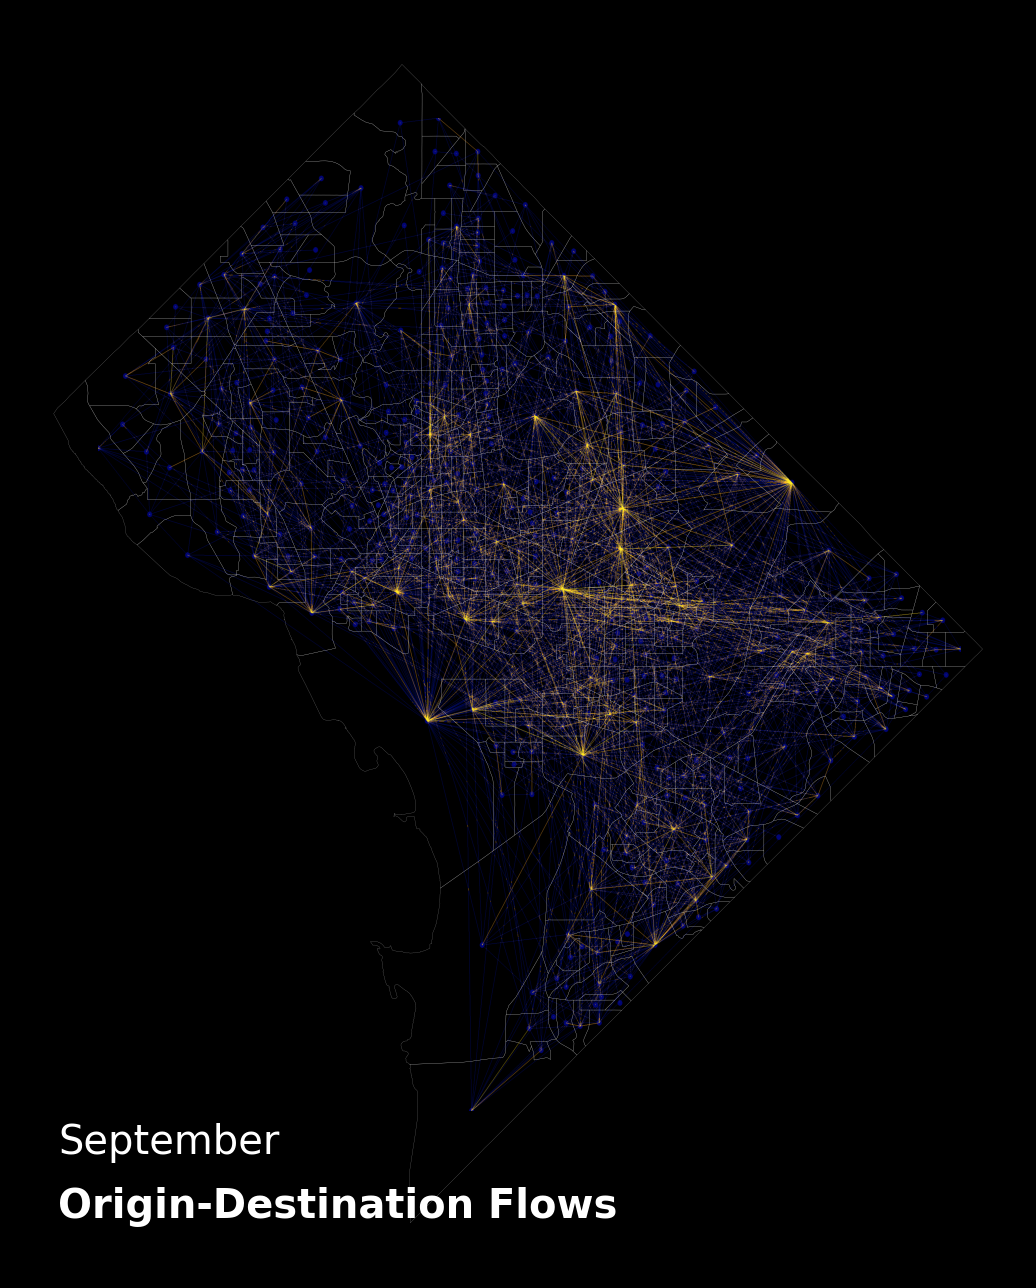

In [17]:
bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]
imgs = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(timeseries.month.unique()):
    
    img = plot_graphs_by_month(fig, timeseries, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('dc.gif', imgs, fps=1);

In [19]:
fips = '42101'

In [20]:
state = fips[:2]
county = fips[2:]

where_clause = f"STATE = {state} AND COUNTY = {county}"
shape = acs.mapservice.layers[10].query(where=where_clause)
    
shape = shape.to_crs(3857)

/Users/andrewrenninger/anaconda3/envs/sandbox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [21]:
nodes = get_nodes(fips)

In [22]:
timeseries = list()

for month in months:
        
        temp = get_edges(fips, month, nodes.reset_index()['cbg'])
        temp['month'] = month
        
        timeseries.append(temp)

timeseries = pd.concat(timeseries, ignore_index=True)

In [23]:
timeseries['month'] = timeseries['month'].astype('int64')

In [25]:
def plot_graphs_by_month(fig, data, nodes, month, x_range, y_range):
    
    temp = data[data['month']==month].drop('month', axis=1)
    
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.85,
        0.05,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
    )
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
    
    ax.text(
        0.85,
        0.1,
        months[month-1],
        color="white",
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
    )
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

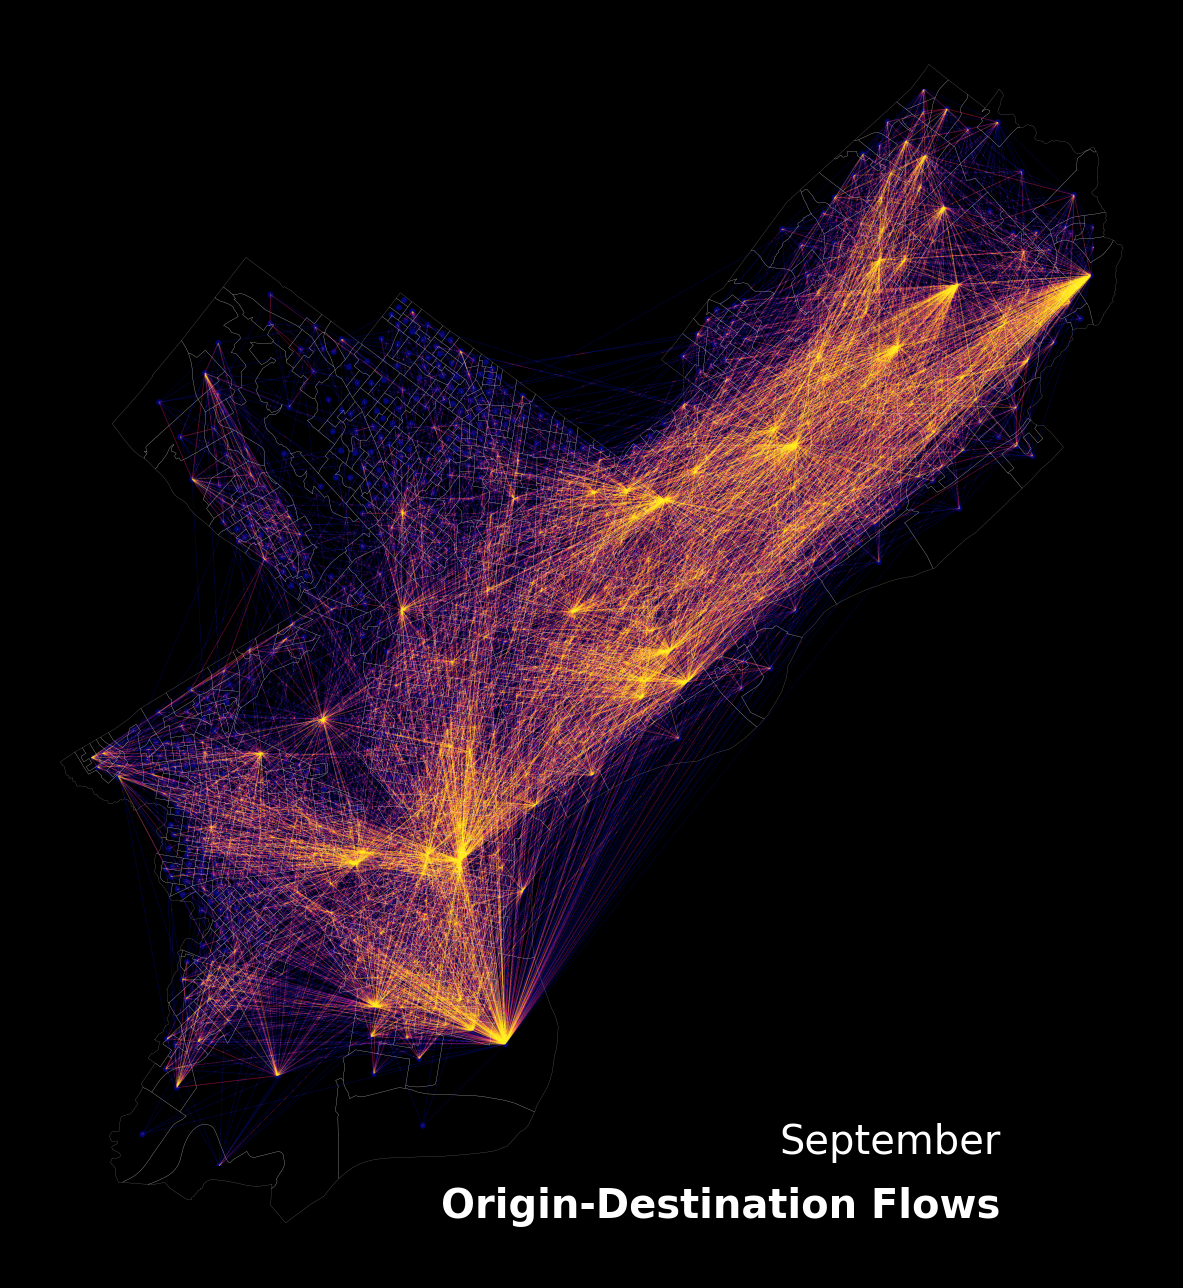

In [26]:
bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]
imgs = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(timeseries.month.unique()):
    
    img = plot_graphs_by_month(fig, timeseries, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('phila.gif', imgs, fps=1);